nu0 =  120
Setting interpolant.


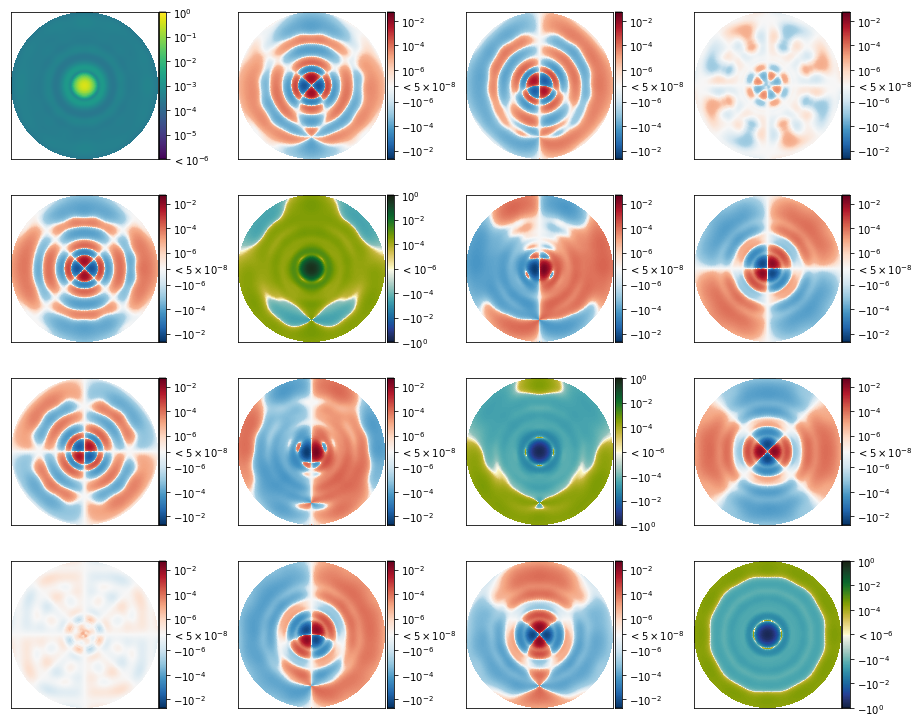

nu0 =  160
Setting interpolant.


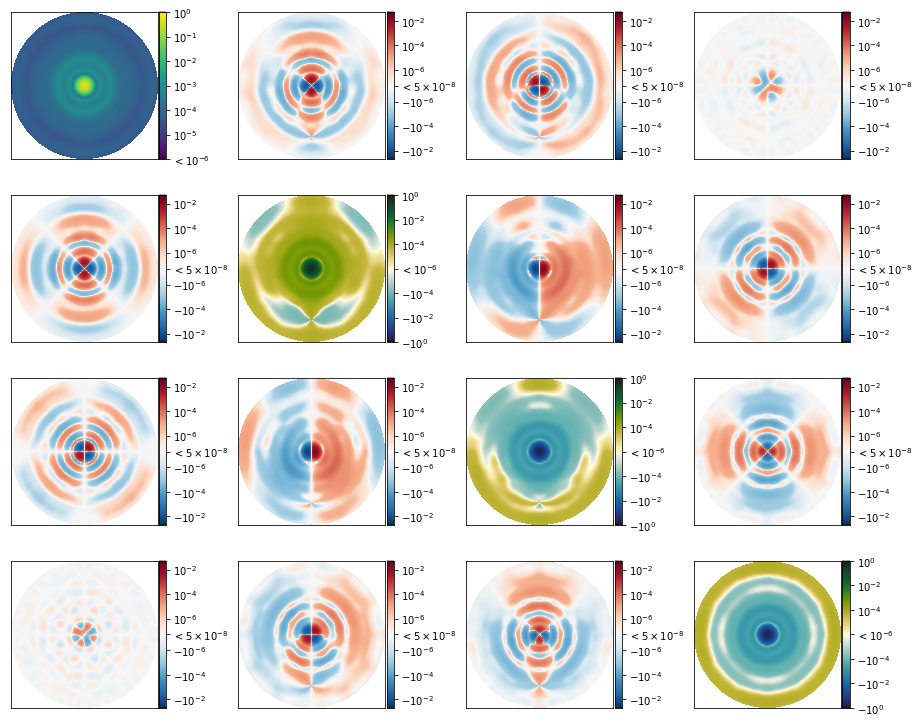

In [8]:
#!/bin/sh

#  Inspired by cst2jones.py
#  
#   Simulation of Instrumental Direction Dependent Mueller Matrix at 120 MHz and 160 MHz
#
#  Created by Zacchary Martinot.
#  
#  You'll need numba, colorcet, cmocean

"""
You will need to install numba, colorcet, cmocean. In kohn18_analysis/FigurePlotting/Data/ 
You will need to clone the cst2ijones directory
you will see HERA_4.9m_E-pattern_ 118MHZ to 162MHz.zip. Unzip it and then you'll see 10 CST text files. 

You will need to make two changes to this script: 
    (1) sys.path.insert(0,'/users/tashaleebillings/') to your own. This should point to 
    Zac's https://github.com/zacharymartinot/cst2ijones directory that you cloned.
    (2) The txtname function needs to change.
        def txtname(n):
            if n not in range(50,251):
                raise ValueError('no data at that frequency.')
            fname = '/Users/tashaleebillings/kohn18_analysis/FigurePlotting/Data/HERA_4.9m_E-pattern_ {0}MHz.txt'.format(str(n))
            return fname
        The fname should point towards where the 10 CST files are located
"""

import numpy as np, healpy as hp, matplotlib.pyplot as plt
import os,sys
import colorcet as cc
ccc = cc.m_cyclic_grey_15_85_c0_s25
import matplotlib
import cmocean

from mpl_toolkits.axes_grid1 import AxesGrid
from astropy.io import fits
from astropy import wcs

sys.path.insert(0,'/users/tashaleebillings/')
from cst2ijones.jones_matrix_field  import InstrumentalJonesMatrixField
from cst2ijones.plotting import PlotMueller
from cst2ijones import spherical_coordinates_basis_transformation as scbt

def StokesMatrix(n):
    if n not in [0,1,2,3]: raise Exception('Input must be an integer in [0,1,2,3]')
    
    if n == 0:
        p = np.array([[1.,0],[0.,1.]])
    elif n == 1:
        p = np.array([[1.,0],[0,-1.]])
    elif n == 2:
        p = np.array([[0,1.],[1.,0]])
    elif n == 3:
        p = np.array([[0., -1j],[1j,0]])
    
    return p

def MuellerMatrixElement(J,i,j):
    
    Pi = StokesMatrix(i)
    Pj = StokesMatrix(j)
    
    M_ij = np.einsum('...ab,...bc,...cd,...ad',Pi,J,Pj,J.conj()) / 2.
    
    M_ij = np.real(M_ij)
    
    return M_ij

def PlotMueller(jones):
    npix = jones.shape[0]
    nside = hp.npix2nside(npix)
    xsize = 1600
    reso = 120*180*np.sqrt(2.)/np.pi /(xsize-1)
    LambProj = hp.projector.AzimuthalProj(xsize=xsize,reso=reso, lamb=True, half_sky=True, rot=[0,30.72])
    p2v = lambda x,y,z: hp.vec2pix(nside,x,y,-z)
    
    logthresh = 4
    linscale = 2
    fig = plt.figure(figsize=(12,12))
    grid = AxesGrid(fig,(1,1,1),
                    nrows_ncols=(4,4),
                    axes_pad=(1.0,0.5),
                    label_mode='all',
                    share_all=False,
                    cbar_location='right',
                    cbar_mode='each',
                    cbar_size='5%',
                    cbar_pad='1%',
                    )
    for i in range(4):
        for j in range(4):
            M_ij = MuellerMatrixElement(jones, i, j)/2.
            img_d = LambProj.projmap(M_ij, p2v)
            
            if i == j == 0:
                cmap = 'viridis'
                vmin = 0
                vmax = 1
                                            
                tick_locs = list(np.linspace(0,1,7, endpoint=True))
                tick_labels = [r'$ < 10^{-6}$',
                               r'$10^{-5}$',
                               r'$10^{-4}$',
                               r'$10^{-3}$',
                               r'$10^{-2}$',
                               r'$10^{-1}$',
                               r'$10^{0}$']
                                                
            elif i != j:
                cmap='RdBu_r'
                vmin=-0.05
                vmax=0.05
                                                                
                d = np.log10(5) * np.diff(np.linspace(vmax*1e-6,vmax,7))[0]
                q = np.linspace(vmax*1e-6,vmax,7)[0::2] - d
                tick_locs = list(np.r_[-np.flipud(q)[:-1],[0], q[1:]])
                tick_labels = [r'$-10^{-2}$',
                               r'$-10^{-4}$',
                               r'$-10^{-6}$',
                               r'$< 5 \times 10^{-8}$',
                               r'$10^{-6}$',
                               r'$10^{-4}$',
                               r'$10^{-2}$']
                                                                    
            else:
                cmap=cmocean.cm.delta
                vmin=-1.
                vmax=1
                                                                                    
                q = np.linspace(vmax*1e-6, vmax,7)[0::2]
                tick_locs = list(np.r_[-np.flipud(q)[:-1],[0], q[1:]])
                tick_labels = [r'$-10^{0}$',
                               r'$-10^{-2}$',
                               r'$-10^{-4}$',
                               r'$< 10^{-6}$',
                               r'$10^{-4}$',
                               r'$10^{-2}$',
                               r'$10^{0}$']
            n = 4 * i + j
            im = grid[n].imshow(img_d, interpolation='none',
                                cmap=cmap,
                                aspect='equal',
                                vmin=vmin,
                                vmax=vmax,)
                                                                                                                
            grid[n].set_xticks([])
            grid[n].set_yticks([])
            
            cbar = grid.cbar_axes[n].colorbar(im, ticks=tick_locs)
            grid.cbar_axes[n].set_yticklabels(tick_labels)
            
            im.set_norm(matplotlib.colors.SymLogNorm(10**-logthresh,linscale, vmin=vmin,vmax=vmax))
        plt.tight_layout(w_pad=0.5, h_pad=1.0)

def txtname(n):
    if n not in range(50,251):
        raise ValueError('no data at that frequency.')
    fname = '/Users/tashaleebillings/Desktop/HERA_4.9m_E-pattern_ {0}MHz.txt'.format(str(n))
    return fname

low_nu = range(118,123,1)
high_nu = range(158,163,1)

low_high=[low_nu,high_nu]

for lh in low_high:
    print "nu0 = ", lh[2]
    nu_nodes = lh
    
    input_files = [txtname(n) for n in nu_nodes]
    
    iJMF = InstrumentalJonesMatrixField(input_files, nu_nodes)
    
    z0_cza = np.radians(120.7215)
    z0 = scbt.r_hat(z0_cza, 0.)
    
    RotAxis = np.array([0,-1,0])
    RotAngle = z0_cza
    
    R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)
    
    nside = 128
    npix = hp.nside2npix(nside)
    hpxidx = np.arange(npix)
    dH, aH = hp.pix2ang(nside, hpxidx)
    thH, phiH = scbt.spherical_coordinates_map(R_z0, dH, aH)
    phiH = 2.*np.pi - phiH
    
    nu_axis = np.array([lh[2]])#np.linspace(lh[2]-1.,lh[2]+1., 3, endpoint=True)
    
    ijones = iJMF(nu_axis, thH, phiH, R_z0.T)
    
    ijones[:,:,:,0] *= -1.
    
    PlotMueller(ijones[0])
    
    # plt.savefig('VivaldiPlots/{}MHz.png'.format(nu0), dpi=80, bbox_inches='tight')
    #plt.show()


In [9]:
pwd

u'/Users/tashaleebillings'